<img src="../assets/images/Cover.png" alt="Cover" title="AI2E Cover" />

### Quiz on what we did so far ! 

**1- What does a neuron compute ?**

- [ ] A neuron computes an activation function followed by a linear function (z = Wx + b)
- [ ] A neuron computes a linear function (z = Wx + b) followed by an activation function
- [ ] A neuron computes a function g that scales the input x linearly (Wx + b)
- [ ] A neuron computes the mean of all features before applying the output to an activation function


**2- Consider the two following random arrays "a" and "b":**

    ```
    a = np.random.randn(2, 3) # a.shape = (2, 3)
    b = np.random.randn(2, 1) # b.shape = (2, 1)
    c = a + b
    ```
  **What will be the shape of "c"?**
  
  
**3- Suppose img is a (32,32,3) array, representing a 32x32 image with 3 color channels red, green and blue. How do you reshape this into a column vector?**

**4- Among the following, which ones are "hyperparameters"?**
- [ ] size of the hidden layers
- [ ] learning rate α
- [ ] number of iterations
- [ ] number of layers L in the neural network


**5- Say you're training a model. If the output from the training process looks as shown below, what action would you take on the learning rate to improve the training?** 

```
Epoch 1, Batch 1, Training Error: 8.4181
Epoch 1, Batch 2, Training Error: 8.4177
Epoch 1, Batch 3, Training Error: 8.4177
Epoch 1, Batch 4, Training Error: 8.4173
Epoch 1, Batch 5, Training Error: 8.4169
```

- [ ] Decrease the learning rate 
- [ ] Increase the learning rate 
- [ ] Try to train again

```
Epoch 1, Batch 1, Training Error: 8.71
Epoch 1, Batch 2, Training Error: 3.25
Epoch 1, Batch 3, Training Error: 4.93
Epoch 1, Batch 4, Training Error: 3.30
Epoch 1, Batch 5, Training Error: 4.82
```

- [ ] Decrease the learning rate 
- [ ] Increase the learning rate 
- [ ] Use an adaptive learning rate 


**6- How do Long Short Term Memory (LSTM) cells and Gated Recurrent Unit (GRU) cells compare?**

- [ ] LSTM ARE BETTER ! 
- [ ] GRU ARE BETTER ! 
- [ ] What are these ? 


## Text Classification 
In this workshop, we will try to solve Zindi challenge : https://zindi.africa/competitions/basic-needs-basic-rights-kenya-tech4mentalhealth 

The objective of this challenge is to develop a machine learning model that classifies statements and questions expressed by university students in Kenya when speaking about the mental health challenges they struggle with. The four categories are depression, suicide, alchoholism, and drug abuse.


In [105]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import re
import spacy # NLP Library 

import torch 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn 
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error

In [106]:
data = pd.read_csv("dataset/Train.csv")
data.head(10)

,ID,text,label
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression
1,9JDAGUV3,Why do I get hallucinations?,Drugs
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression
3,6UY7DX6Q,Why is life important?,Suicide
4,FYC0FTFB,How could I be helped to go through the depres...,Depression
5,V6VSDJ5I,What are the effects of depression to ones health,Depression
6,9736J4UE,Why is everything so hard to deal with in this...,Depression
7,AY8L479Y,I feel emotionally overwhelmed,Depression
8,OSFJV5EC,How to manage taking alcohol?,Alcohol
9,U4SGUGGM,Is heaven open for us who smoke bhang?,Drugs


In [107]:
data["label"].unique()

array(['Depression', 'Drugs', 'Suicide', 'Alcohol'], dtype=object)

In [108]:
np.size(data["ID"].unique())

616

In [109]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      616 non-null    object
 1   text    616 non-null    object
 2   label   616 non-null    object
dtypes: object(3)
memory usage: 14.6+ KB


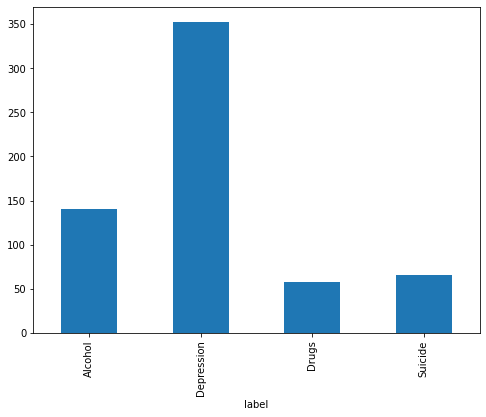

In [110]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
data.groupby("label").ID.count().plot.bar(ylim=0)
plt.show()

In [111]:
def preprocess(text):
    text = text.lower()
    
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    
    return text

In [112]:
data['text'] = data["text"].apply(preprocess)

In [113]:
texts = ' '.join(data["text"])
texts

'i feel that it was better i dieam happy why do i get hallucinations QUESTION_MARK i am stresseed due to lack of financial support in school why is life important QUESTION_MARK how could i be helped to go through the depression QUESTION_MARK what are the effects of depression to ones health why is everything so hard to deal with in this life i feel emotionally overwhelmed how to manage taking alcohol QUESTION_MARK is heaven open for us who smoke bhang QUESTION_MARK how to survive without money QUESTION_MARK how do i stop this QUESTION_MARK what do i do when life becomes unbearable QUESTION_MARK i was ever sad COMMA alone and always on drugsnow i know how to cope with negative aspects in my life i feel empty COMMA absent minded i experienced depression in my studies i feel like am alone in this world i feel low and out of place what should i do to get out of depression QUESTION_MARK how can i stop using alcohol QUESTION_MARK i feel hopeless COMMA unworthy and useless how do i cope with 

In [114]:
vocabulary = texts.split()
word_counts = Counter(vocabulary)
trimmed_words = [word for word in vocabulary if word_counts[word] > 5]

In [115]:
def avg_word(sentence):
    try:
        words = sentence.split()
        return (sum(len(word) for word in words)/len(words))
    except:
        return 0

In [116]:
print('Roughly the number of unique words: {}'.format(len({word: None for word in texts.split()})))

Roughly the number of unique words: 845


In [117]:
avg_word(texts)

4.555141287284145

In [118]:
data["size_text"] = data["text"].str.len()
data.describe()

,size_text
count,616.000000
mean,44.956169
std,22.759035
min,8.000000
25%,30.000000
50%,41.000000
75%,54.000000
max,195.000000


In [119]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

data['label'] = labelencoder.fit_transform(data['label'])
data.head()

,ID,text,label,size_text
0,SUAVK39Z,i feel that it was better i dieam happy,1,39
1,9JDAGUV3,why do i get hallucinations QUESTION_MARK,2,41
2,419WR1LQ,i am stresseed due to lack of financial suppor...,1,57
3,6UY7DX6Q,why is life important QUESTION_MARK,3,35
4,FYC0FTFB,how could i be helped to go through the depres...,1,64


In [120]:
categories = labelencoder.classes_

In [121]:
train, test = train_test_split(data, random_state=42, test_size=0.33, shuffle=True)
X_train = train.text
X_test = test.text
print(X_train.shape)
print(X_test.shape)

(412,)
(204,)


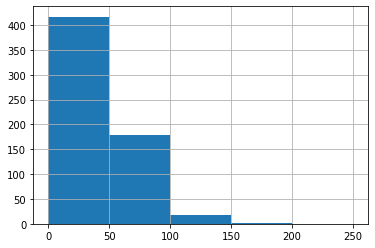

In [122]:
lens = data.text.str.len()
lens.hist(bins = np.arange(0,300,50))

## Embeddings 

### What's an embedding ? 

<img src="images/absurd.gif" align="right" width="200px"/>

```  
In the context of neural networks, embeddings are low-dimensional, 
learned continuous vector representations of discrete variables. --- Google 
```

``` 
An embedding (or imbedding[1]) is one instance of some mathematical
structure contained within another instance, such as a group that is 
a subgroup. --- Wikipedia
```


**1. We can represent people (and things) as vectors of numbers (which is great for machines)**

**2. We can easily calculate how similar vectors are to each other.**


### 1- One hot Encoding

In [123]:
sentence1 = "This is a great day".lower()
sentence2 = "This is a good day".lower()

documents = (sentence1, sentence2)

sentence1 = sentence1.split()
sentence2 = sentence2.split()

vocabulary = list(set(sentence1 + sentence2))
vocabulary = np.array(vocabulary).reshape(-1, 1)
print(vocabulary)
print("\n")

one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder = one_hot_encoder.fit_transform(vocabulary)
print(one_hot_encoder)


[['day']
 ['good']
 ['this']
 ['a']
 ['great']
 ['is']]


[[0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]


In [124]:
print("Similarity between this and good : ")
print(cosine_similarity(one_hot_encoder[0,:].reshape(1, -1), one_hot_encoder[1,:].reshape(1, -1)))

print("Similarity between good and great : ")
print(cosine_similarity(one_hot_encoder[2,:].reshape(1, -1), one_hot_encoder[1,:].reshape(1, -1)))

Similarity between this and good : 
[[0.]]
Similarity between good and great : 
[[0.]]


### 2- TFIDF 

**TF-IDF** for a word in a document is calculated by multiplying two different metrics:

- The **term frequency** of a word in a document. There are several ways of calculating this frequency, with the simplest being a raw count of instances a word appears in a document. Then, there are ways to adjust the frequency, by length of a document, or by the raw frequency of the most frequent word in a document.

- The **inverse document frequency of the word** across a set of documents. This means, how common or rare a word is in the entire document set. The closer it is to 0, the more common a word is. This metric can be calculated by taking the total number of documents, dividing it by the number of documents that contain a word, and calculating the logarithm.

In [125]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
tfidf_matrix

<2x5 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [126]:
cosine_similarity(tfidf_matrix[0:1], tfidf_matrix)

array([[1.        , 0.60297482]])

In [127]:
tfidf_vectorizer.get_feature_names()

['day', 'good', 'great', 'is', 'this']

In [128]:
df = pd.DataFrame(tfidf_matrix.toarray(), columns = tfidf_vectorizer.get_feature_names())
df

,day,good,great,is,this
0,0.448321,0.000000,0.630099,0.448321,0.448321
1,0.448321,0.630099,0.000000,0.448321,0.448321


In [129]:
# Define a pipeline combining a text feature extractor with multi label classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words="english")),
                ('classifier', MultinomialNB(
                    fit_prior=True, class_prior=None)),
            ])


print('... Processing')
NB_pipeline.fit(X_train, train["label"])

prediction = NB_pipeline.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(test['label'], prediction)))

... Processing
Test accuracy is 0.7254901960784313


In [130]:
prediction

array([0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 3, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 2, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0])

### 3- Analogy Preserving Embedding

<img src="images/embeddings.png" />

<p align="right">Credits to https://www.tensorflow.org/tutorials/word2vec </p>


You can download the pretrained vectors we're using here from : https://nlp.stanford.edu/projects/glove/

In [131]:
embeddings_dict = {}
with open("dataset/glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [132]:
embeddings_dict["man"]

array([-0.094386,  0.43007 , -0.17224 , -0.45529 ,  1.6447  ,  0.40335 ,
       -0.37263 ,  0.25071 , -0.10588 ,  0.10778 , -0.10848 ,  0.15181 ,
       -0.65396 ,  0.55054 ,  0.59591 , -0.46278 ,  0.11847 ,  0.64448 ,
       -0.70948 ,  0.23947 , -0.82905 ,  1.272   ,  0.033021,  0.2935  ,
        0.3911  , -2.8094  , -0.70745 ,  0.4106  ,  0.3894  , -0.2913  ,
        2.6124  , -0.34576 , -0.16832 ,  0.25154 ,  0.31216 ,  0.31639 ,
        0.12539 , -0.012646,  0.22297 , -0.56585 , -0.086264,  0.62549 ,
       -0.0576  ,  0.29375 ,  0.66005 , -0.53115 , -0.48233 , -0.97925 ,
        0.53135 , -0.11725 ], dtype=float32)

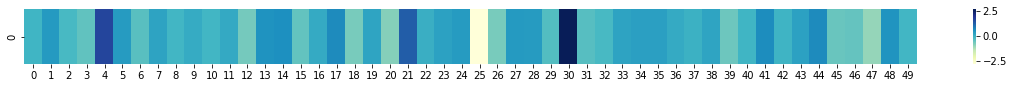

In [133]:
fig, ax = plt.subplots(figsize=(20,1))
sns.heatmap([embeddings_dict["man"]], cmap="YlGnBu")

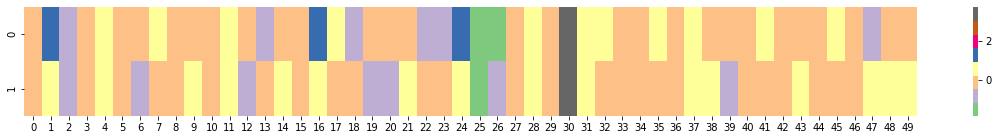

In [134]:
great = embeddings_dict["great"]
good = embeddings_dict["good"]

fig, ax = plt.subplots(figsize=(20,2))
sns.heatmap([great,good], cmap="Accent")

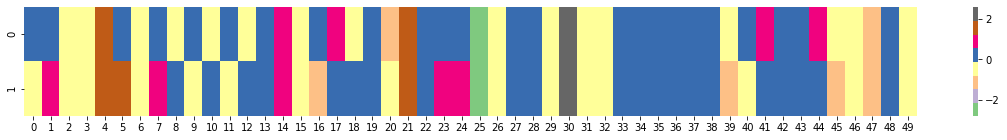

In [135]:
man = embeddings_dict["man"]
woman = embeddings_dict["woman"]

fig, ax = plt.subplots(figsize=(20,2))
sns.heatmap([man,woman], cmap="Accent")

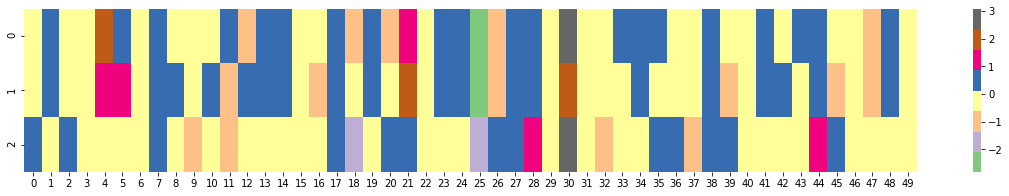

In [136]:
fire = embeddings_dict["fire"]

fig, ax = plt.subplots(figsize=(20,3))
sns.heatmap([man,woman, fire], cmap="Accent")

In [137]:
king = embeddings_dict["king"]
queen = embeddings_dict["queen"]

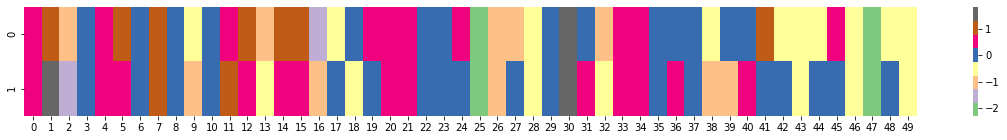

In [138]:
q = king - man + woman

fig, ax = plt.subplots(figsize=(20,2))
sns.heatmap([q,queen], cmap="Accent")

In [139]:
from scipy import spatial
def find_closest_embeddings(embedding):
    return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embedding))[1:5]

In [140]:
find_closest_embeddings(q)

['queen', 'prince', 'elizabeth', 'daughter']

In [141]:
spain = embeddings_dict["spain"]
madrid = embeddings_dict["madrid"]

algeria = embeddings_dict["algeria"]
algiers = embeddings_dict["algiers"]

cosine_similarity([spain, madrid, algeria, algiers])

array([[1.        , 0.73931265, 0.60820127, 0.32209387],
       [0.73931265, 1.        , 0.5200254 , 0.506898  ],
       [0.60820127, 0.5200254 , 0.99999994, 0.71740276],
       [0.32209387, 0.506898  , 0.71740276, 1.0000001 ]], dtype=float32)

#### Word2Vec

Word2vec is a **predictive** based embeddings that uses Neural Networks to obtain each word's embeddings in the vocabulary. 

To achieve Word2Vec, we can use two different algorithms : 
1. **Continuous Bag of Words**, described in : https://arxiv.org/pdf/1301.3781.pdf
2. **Skip Grams**

Steps to create the embeddings: 
* We get a lot of text data (say, all Wikipedia articles, for example). then
* We have a window (say, of three words) that we slide against all of that text.
* The sliding window generates training samples for our model

<img src="images/CBOW.png" />


#### Looking both ways 
<img src="images/back.png" />

#### Skip Grams 
Instead of guessing a word based on its context (the words before and after it), this other architecture tries to guess neighboring words using the current word. We can think of the window it slides against the training text as looking like this:
<img src="images/skip.png" />

#### Negative Sampling 
Our training is expensive from a computational point of view. We need to find a way to reduce this number of computations. 

One way is to split our target into two steps:

* Generate high-quality word embeddings (Don’t worry about next-word prediction).
* Use these high-quality embeddings to train a language model (to do next-word prediction).

<img src="images/neg_sam.png" />

### Word2Vec Process Summary 

1. Pre-process the text we’re training the model against: 
    * Determine the size of the vocabulary 
    * Determine the words of the vocabulary 
2. Create two matrices : 
    * Embedding matrix : (vocab_size, embedding_size) 
    * Context Matrix : (embedding_size, vocab_size) 
3. Initialize them with random values 
4. Start the training : 
    * In each step, take one positive sample (wander, lost) and the negative sample associated with it (wander, frodo). 
    * Look for the embeddings of each word ( wander in the embedding matrix, lost and frodo in the context matrix) 
    * Take the dot product of the input embeddings with the contexts embeddings (calculate the similarity) 
    * Apply the sigmoid to get numbers between 0 and 1 
    * Calculate the error 
    * Update the matrices 
    

In [142]:
data.head()

,ID,text,label,size_text
0,SUAVK39Z,i feel that it was better i dieam happy,1,39
1,9JDAGUV3,why do i get hallucinations QUESTION_MARK,2,41
2,419WR1LQ,i am stresseed due to lack of financial suppor...,1,57
3,6UY7DX6Q,why is life important QUESTION_MARK,3,35
4,FYC0FTFB,how could i be helped to go through the depres...,1,64


In [143]:
import string
def tokenize (text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    return text.split()

In [144]:
tokenize("bla bla bla")

['bla', 'bla', 'bla']

In [145]:
#count number of occurences of each word
counts = Counter()
for index, row in data.iterrows():
    counts.update(tokenize(row['text']))

In [146]:
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 845
num_words after: 362


In [147]:
#creating vocabulary
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [148]:
def encode_sentence(text, vocab2index, N=40):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [149]:
encode_sentence(data["text"][6], vocab2index )

(array([ 9, 22, 38, 39, 40, 15, 41, 42, 20, 43, 23,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0]),
 11)

In [150]:
data['encoded'] = data['text'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
data.head()

,ID,text,label,size_text,encoded
0,SUAVK39Z,i feel that it was better i dieam happy,1,39,"[[2, 3, 4, 5, 6, 7, 2, 1, 8, 0, 0, 0, 0, 0, 0,..."
1,9JDAGUV3,why do i get hallucinations QUESTION_MARK,2,41,"[[9, 10, 2, 11, 12, 13, 0, 0, 0, 0, 0, 0, 0, 0..."
2,419WR1LQ,i am stresseed due to lack of financial suppor...,1,57,"[[2, 14, 1, 1, 15, 16, 17, 18, 19, 20, 21, 0, ..."
3,6UY7DX6Q,why is life important QUESTION_MARK,3,35,"[[9, 22, 23, 24, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
4,FYC0FTFB,how could i be helped to go through the depres...,1,64,"[[25, 26, 2, 27, 28, 15, 29, 30, 31, 32, 13, 0..."


In [151]:
train, test = train_test_split(data, random_state=42, test_size=0.33, shuffle=True)
X_train = train.encoded
X_test = test.encoded
print(X_train.shape)
print(X_test.shape)

(412,)
(204,)


In [152]:
class textDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [153]:
X_train

565    [[2, 269, 1, 87, 17, 48, 0, 0, 0, 0, 0, 0, 0, ...
425    [[33, 34, 31, 35, 17, 52, 13, 0, 0, 0, 0, 0, 0...
167    [[78, 62, 25, 15, 11, 73, 17, 5, 0, 0, 0, 0, 0...
54     [[2, 3, 115, 87, 17, 160, 161, 0, 0, 0, 0, 0, ...
437    [[9, 299, 68, 303, 302, 1, 123, 13, 0, 0, 0, 0...
                             ...                        
71     [[2, 3, 39, 72, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
106    [[2, 14, 59, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
270    [[18, 161, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
435    [[25, 76, 2, 3, 7, 151, 170, 0, 0, 0, 0, 0, 0,...
102    [[25, 10, 2, 158, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0...
Name: encoded, Length: 412, dtype: object

In [154]:
train_ds = textDataset(X_train.values, train["label"].values)
valid_ds = textDataset(X_test.values, test["label"].values)

In [155]:
train_ds.__getitem__(0)

(tensor([  2, 269,   1,  87,  17,  48,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        dtype=torch.int32),
 0,
 6)

In [156]:
def train_model(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.long()
            y = y.long()
            y_pred = model(x, l)
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, val_rmse = validation_metrics(model, val_dl)
        if i % 5 == 1:
            print("train loss %.3f, val loss %.3f, val accuracy %.3f, and val rmse %.3f" % (sum_loss/total, val_loss, val_acc, val_rmse))

def validation_metrics (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y, l in valid_dl:
        x = x.long()
        y = y.long()
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    return sum_loss/total, correct/total, sum_rmse/total

In [157]:
batch_size = 32
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

In [158]:
class LSTM_fixed_len(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 4)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [159]:
model_fixed = LSTM_fixed_len(vocab_size, 40, 64)
train_model(model_fixed, epochs=30, lr=0.01)

train loss 1.079, val loss 1.227, val accuracy 0.525, and val rmse 0.933
train loss 1.098, val loss 1.217, val accuracy 0.525, and val rmse 0.933
train loss 1.076, val loss 1.211, val accuracy 0.525, and val rmse 0.933
train loss 1.081, val loss 1.212, val accuracy 0.525, and val rmse 0.933
train loss 1.074, val loss 1.215, val accuracy 0.525, and val rmse 0.933
train loss 0.659, val loss 0.949, val accuracy 0.623, and val rmse 1.239


## Transfer learning ! 

#### What are the best models available?
* XLNET
* Google’s BERT 
* Transformer-XL

To get an overview of each model : https://www.analyticsvidhya.com/blog/2019/03/pretrained-models-get-started-nlp/ 

In [160]:
train_df = pd.DataFrame({
    'text': train["text"],
    'label':train["label"].astype(int)
})

train_df.head()

,text,label
565,i went bankrupt because of alcohol,0
425,what are the effects of bhang QUESTION_MARK,2
167,hopeless and how to get out of it,1
54,i feel depressed because of relationship issues,1
437,why did my close relatives betray me QUESTION_...,1


In [ ]:
from simpletransformers.classification import ClassificationModel

model = ClassificationModel('roberta', 'roberta-base', num_labels=4, args={'learning_rate':1e-5, 'num_train_epochs': 10, 'reprocess_input_data': True, 'overwrite_output_dir': True}, use_cuda=False)

In [ ]:
model.train_model(train_df, num_train_epochs=10)

In [ ]:
sentences = test["text"]
predictions, raw_outputs = model.predict(sentences)

## More on NLP 
* THE BEST : http://jalammar.github.io/ 
* Libraries and models : https://medium.com/dataseries/nlp-libraries-and-pretrained-models-94c9a53a295a